In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

## dataset

In [2]:
ratebeer = pd.read_json("../data/ratebeer_korea.json")

In [3]:
ratebeer.tail()

,reviewScore,reviewTime,reviewText,appearance,aroma,palate,taste,overall,profileName,beerName,beerID,brewerID,ABV,style,imageUrl
94316,3.0,2000-06-14 04:58:02.000,"pale clear golden colour with a fine head, low...",4.0,5.0,3.0,6.0,12.0,Bov,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94317,4.2,2000-06-10 16:51:58.000,"love that skunky smell ! Actually, my fav eve...",4.0,9.0,4.0,8.0,17.0,sallyclub99,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94318,2.7,2000-06-05 08:46:21.000,Much better than American pilsners which isn't...,2.0,5.0,2.0,6.0,12.0,kublai3,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94319,3.3,2000-06-03 23:59:02.000,"A decent, light-German beer. Not bad, but then...",3.0,6.0,3.0,6.0,15.0,Aubrey,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94320,3.3,2000-05-07 01:07:31.000,Beck's is a decent german beer. It's a little...,3.0,6.0,4.0,7.0,13.0,roland,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...


In [4]:
ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93623 entries, 0 to 94320
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reviewScore  93620 non-null  float64
 1   reviewTime   93623 non-null  object 
 2   reviewText   93623 non-null  object 
 3   appearance   92036 non-null  float64
 4   aroma        92036 non-null  float64
 5   palate       92036 non-null  float64
 6   taste        92036 non-null  float64
 7   overall      92036 non-null  float64
 8   profileName  93623 non-null  object 
 9   beerName     93623 non-null  object 
 10  beerID       93623 non-null  int64  
 11  brewerID     93623 non-null  int64  
 12  ABV          93623 non-null  float64
 13  style        93623 non-null  object 
 14  imageUrl     93623 non-null  object 
dtypes: float64(7), int64(2), object(6)
memory usage: 11.4+ MB


In [5]:
# 결측치 제거
ratebeer = ratebeer.dropna(subset=['reviewScore'])
ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93620 entries, 0 to 94320
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reviewScore  93620 non-null  float64
 1   reviewTime   93620 non-null  object 
 2   reviewText   93620 non-null  object 
 3   appearance   92036 non-null  float64
 4   aroma        92036 non-null  float64
 5   palate       92036 non-null  float64
 6   taste        92036 non-null  float64
 7   overall      92036 non-null  float64
 8   profileName  93620 non-null  object 
 9   beerName     93620 non-null  object 
 10  beerID       93620 non-null  int64  
 11  brewerID     93620 non-null  int64  
 12  ABV          93620 non-null  float64
 13  style        93620 non-null  object 
 14  imageUrl     93620 non-null  object 
dtypes: float64(7), int64(2), object(6)
memory usage: 11.4+ MB


### 편의점 유통 맥주만 가져오기

In [6]:
# 전체 데이터에서 한국 편의점 맥주 개수
len(ratebeer['beerName'].unique())

81

### preprocessing

In [7]:
def preprocessing_df(df):
    # rating 전처리
    # df['rating/apperance'] = df['review/appearance'].str.split("/").str[0].astype(int)
    # df['rating/aroma'] = df['review/aroma'].str.split("/").str[0].astype(int)
    # df['rating/palate'] = df['review/palate'].str.split("/").str[0].astype(int)
    # df['rating/taste'] = df['review/taste'].str.split("/").str[0].astype(int)
    # df['rating/overall'] = df['review/overall'].str.split("/").str[0].astype(int)
    
    # overall rating 최대치 5로 변환
    # df['rating/overall'] = df['rating/overall'] / 20 * 5
    
    # item, user, rating만 추출
    df = df[['beerID', 'profileName', 'reviewScore', 'imageUrl']]
    df.rename(columns={'beerID' : 'item', 'profileName' : 'user', 'reviewScore' : 'rating'}, inplace = True) 
    
    # 유저 리뷰 수 개산
    df['user/reviewcount'] = df.groupby('user')['user'].transform('count')
    # 리뷰 수가 10개 이상인 유저만 남김 
    df = df[(df['user/reviewcount'] > 10)]
    
    df.drop(columns=['user/reviewcount'], inplace=True)
    
    num_users = df.user.unique().shape[0]
    num_items = df.item.unique().shape[0]
    return df, num_users, num_items

### Statistics of the Dataset

In [8]:
data, num_users, num_items = preprocessing_df(ratebeer)
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 2737, number of items: 80
matrix sparsity: 0.740930
    item        user  rating  \
0  75661  Grzesiek79     1.3   
1  75661    GriZZZly     2.7   
2  75661   bdleedahl     3.3   
3  75661    DoctorHU     2.6   
4  75661     McTapps     2.5   

                                            imageUrl  
0  https://res.cloudinary.com/ratebeer/image/uplo...  
1  https://res.cloudinary.com/ratebeer/image/uplo...  
2  https://res.cloudinary.com/ratebeer/image/uplo...  
3  https://res.cloudinary.com/ratebeer/image/uplo...  
4  https://res.cloudinary.com/ratebeer/image/uplo...  


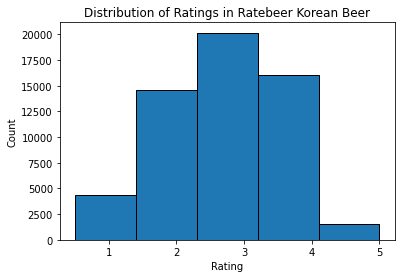

In [9]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Ratebeer Korean Beer')
plt.show()

### Label Encoding

In [10]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['user'].values)
data['item_id_idx'] = item_le.fit_transform(data['item'].values)

# data.drop(columns=['user', 'item_id'], inplace=True)

### Loading the data

In [11]:
class BeerDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.df = df
        self.mode = mode
        self.train_size = 0.8
        self.val_size = 0.1
        self.test_size = 1 - self.train_size - self.val_size 

        self.num_items = len(self.df['item_id_idx'].unique())
        self.num_users = len(self.df['user_id_idx'].unique())
        
        n_val = int(self.num_users * self.val_size)
        n_test = int(self.num_users * self.test_size)
        
        random.seed(42)
        
        val_indices = set(random.choices(range(self.num_users), k=n_val))
        test_indices = set(random.choices(list(set(range(self.num_users)) - val_indices), k=n_test))
        train_indices = set(range(self.num_users)) - val_indices - test_indices
    
        # self.train_df, self.test_df = train_test_split(self.df, test_size=self.test_size, train_size=self.train_size, stratify = self.df['user_id_idx'].values, random_state=42)
                        
        if self.mode == 'train':
            self.df = self.df[self.df['user_id_idx'].isin(train_indices)]
        elif self.mode == 'val':
            self.df = self.df[self.df['user_id_idx'].isin(val_indices)]
        else:
            self.df = self.df[self.df['user_id_idx'].isin(test_indices)]

        self.users = torch.tensor(self.df['user_id_idx'].values)
        self.items = torch.tensor(self.df['item_id_idx'].values)
        self.ratings = torch.tensor(self.df['rating'].values)
        
        self.inter_mat = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_users, self.num_items))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[user][item] = rating

        return inter_mat

    def __len__(self):
        return len(self.inter_mat)

    def __getitem__(self, index):
        inter_mat = torch.tensor(self.inter_mat[index]).float()

        return index, inter_mat

### Autorec Model

In [12]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_items, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Linear(num_items, num_hidden)
        self.sigmoid = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_items)
        self.dropout = nn.Dropout(dropout)

    def forward(self, mat):
        hidden = self.dropout(self.sigmoid(self.encoder(mat)))
        pred = self.decoder(hidden)
        
        return pred

###  Model train, validcation

In [13]:
def train(model, train_iter, criterion, optm, device):
    model.train() # to train mode
    loss_sum = 0

    for _, inter_mat in train_iter:
        inter_mat = inter_mat.to(device)    

        preds = model(inter_mat)
        loss = criterion(preds, inter_mat)

        # Update
        optm.zero_grad()      # reset gradient 
        loss.backward()      # backpropagate
        optm.step()      # optimizer update
        
        loss_sum += loss.item()
        
    loss_avg = loss_sum / len(train_iter)

    return loss_avg

In [14]:
def validation(model, valid_iter, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum = 0

        for _, inter_mat in valid_iter:
            inter_mat = inter_mat.to(device) 

            preds = model(inter_mat)
            loss = criterion(preds, inter_mat)            

            loss_sum += loss.item()

    loss_avg = loss_sum / len(valid_iter)

    return loss_avg

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
lr = 0.001
batch_size = 64

num_items = data.item_id_idx.nunique()
num_hidden = 100

In [16]:
train_dataset = BeerDataset(df=data, mode='train')
val_dataset = BeerDataset(df=data, mode='val')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [17]:
model = AutoRec(num_hidden, num_items).to(device)
loss = nn.MSELoss()
optm = optim.Adam(model.parameters(),lr=lr)

epoch: 0, train Loss: 1.0593, test Loss: 0.4452
epoch: 1, train Loss: 0.7599, test Loss: 0.2982
epoch: 2, train Loss: 0.7007, test Loss: 0.2291
epoch: 3, train Loss: 0.6485, test Loss: 0.1822
epoch: 4, train Loss: 0.6028, test Loss: 0.1469
epoch: 5, train Loss: 0.5609, test Loss: 0.1198
epoch: 6, train Loss: 0.5212, test Loss: 0.1006
epoch: 7, train Loss: 0.4847, test Loss: 0.0867
epoch: 8, train Loss: 0.4518, test Loss: 0.0764
epoch: 9, train Loss: 0.4195, test Loss: 0.0665
epoch: 10, train Loss: 0.3899, test Loss: 0.0579
epoch: 11, train Loss: 0.3631, test Loss: 0.0521
epoch: 12, train Loss: 0.3382, test Loss: 0.0475
epoch: 13, train Loss: 0.3160, test Loss: 0.0423
epoch: 14, train Loss: 0.2938, test Loss: 0.0377
epoch: 15, train Loss: 0.2736, test Loss: 0.0350
epoch: 16, train Loss: 0.2574, test Loss: 0.0320
epoch: 17, train Loss: 0.2408, test Loss: 0.0295
epoch: 18, train Loss: 0.2264, test Loss: 0.0273
epoch: 19, train Loss: 0.2128, test Loss: 0.0249
epoch: 20, train Loss: 0.2003,

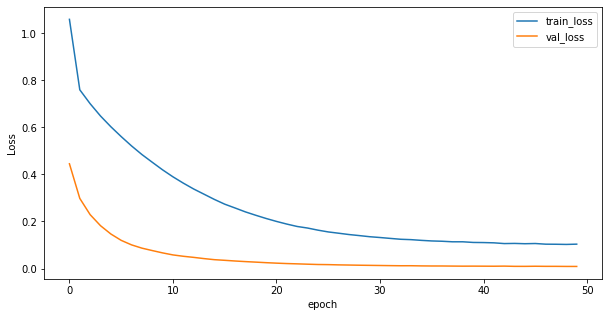

In [18]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    train_loss = train(model, train_dataloader, loss, optm, device)
    val_loss = validation(model, val_dataloader, loss, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {val_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(val_losses,label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
PATH = '../model/autorec_crawling.pt'
torch.save(model.state_dict(), PATH)

## inference

### 모델 불러오기

In [20]:
model = AutoRec(num_hidden, num_items).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### 평가지표 함수

In [21]:
def ndcg_k(actual, predicted, topk):
    res = 0
    for user_id in range(len(actual)):
        k = min(topk, len(actual[user_id]))
        idcg = idcg_k(k)
        dcg_k = sum(
            [
                int(predicted[user_id][j] in set(actual[user_id])) / math.log(j + 2, 2)
                for j in range(topk)
            ]
        )
        res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k(actual, predicted, topk):
    sum_recall = 0.0
    num_users = len(predicted)
    true_users = 0
    for i in range(num_users):
        act_set = set(actual[i])
        pred_set = set(predicted[i][:topk])
        if len(act_set) != 0:
            sum_recall += len(act_set & pred_set) / float(len(act_set))
            true_users += 1
    return sum_recall / true_users

In [22]:
def inference(model, test_iter, test_matrix, device, topk = 4):
    pred_list = None
    answer_list = None
    with torch.no_grad():
        model.eval()

        for i, (user_ids, inter_mat) in enumerate(test_iter):
            inter_mat = inter_mat.to(device)
            
            rating_pred = model(inter_mat)
            
            rating_pred = rating_pred.cpu().data.numpy().copy()
            
            batch_user_index = user_ids.cpu().numpy()
            answers = test_matrix.argsort(axis = 1)[batch_user_index, -topk:][:, ::-1]
            # rating_pred[test_matrix[batch_user_index] > 0] = 0
            
            ind = np.argpartition(rating_pred, -topk)[:, -topk:]
            
            arr_ind = rating_pred[np.arange(len(rating_pred))[:, None], ind]

            arr_ind_argsort = np.argsort(arr_ind)[np.arange(len(rating_pred)), ::-1]

            batch_pred_list = ind[
                np.arange(len(rating_pred))[:, None], arr_ind_argsort
            ]

            if i == 0:
                pred_list = batch_pred_list
                answer_list = answers
            else:
                pred_list = np.append(pred_list, batch_pred_list, axis=0)
                answer_list = np.append(
                        answer_list, answers, axis=0
                )
            
        recall = recall_at_k(answer_list, pred_list, topk)
        ndcg = ndcg_k(answer_list, pred_list, topk)
        
        print(f'recall@{topk} = {recall}, ndcg@{topk} = {ndcg}')
    return pred_list, answer_list

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
lr = 0.001
batch_size = 1

num_items = data.item_id_idx.nunique()
num_hidden = 100

In [24]:
test_dataset = BeerDataset(df=data, mode='test')

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_matrix = test_dataset.inter_mat

### inference 수행

In [25]:
pred_list, answer_list = inference(model, test_dataloader, test_matrix, device, topk=4)

recall@4 = 0.3026123492875411, ndcg@4 = 0.2315629239800554


In [26]:
# test 데이터 user 목록
test_dataset.df.user_id_idx.unique()

array([2379,   78,  870, 1140,   15, 2603, 2466, 1747, 1680,   26, 1043,
       1654,   73,  403,   51,   69,  756,    5,  174,  856, 1902, 2540,
       2471,  414,  299,  699, 2417,  903,  530,  763,   65, 1149, 2635,
        734, 2414, 1835, 1136,  190, 1846,   74, 1863,  542,  225, 2233,
       2451, 2594, 1194,  576, 1784,  526, 2080, 1047,  350, 1588,  866,
       2151, 1215, 2092,  347, 2342, 2312,  852, 1299, 2538,  420, 2056,
        294, 2104,  298, 2317, 1181,  965,  692, 2134,  316,    2, 2172,
       1942,  716, 1151, 1303,  727, 1788, 2054,  605,  459, 1152,  754,
       2016, 2409,  774, 1663,  929, 1906,  318,  201,  541, 2045,  738,
        832, 1936, 2268, 1908, 1994, 1970, 2337,  207, 1340,  676, 1917,
        619,  640, 1119, 1745,  768,  255, 2359,  917, 1499, 2699,  795,
        833,   14, 2097, 1657, 2028, 1121, 1116,  379,  818,  678,  372,
       1283, 1800, 1268, 1859, 2107, 1478,  212, 2435,  791, 2174, 1687,
       1197, 2235,  563, 2649, 2525, 2565, 1400, 20

In [27]:
# 모델 예측 선호 맥주 top4
pred_list[2379]

array([ 6, 23, 18, 27])

In [28]:
# 유저 실제 선호 맥주 top4
answer_list[2379]

array([23,  6, 18, 58])

In [29]:
test_matrix[2379]

array([2.3, 0. , 0. , 3. , 2.5, 0. , 4.3, 1.1, 2. , 3.4, 1.8, 2.4, 1.5,
       2.4, 0. , 2.7, 2.5, 1.7, 3.6, 3. , 2.8, 2.8, 0. , 4.3, 3.2, 3.1,
       2.8, 3.3, 0. , 2.8, 0. , 2.2, 0. , 0. , 1.9, 2.1, 0. , 0. , 0. ,
       2. , 0. , 0. , 0. , 0. , 3. , 2.3, 0. , 0. , 0. , 0. , 2. , 3. ,
       0. , 0. , 0. , 0. , 2.9, 0. , 3.5, 2.7, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ])

### 웹사이트 inference

In [30]:
# 웹사이트 input
x_test = torch.tensor([2.3, 0. , 0. , 3. , 2.5, 0. , 4.3, 1.1, 2. , 3.4, 1.8, 2.4, 1.5,
       2.4, 0. , 2.7, 2.5, 1.7, 3.6, 3. , 2.8, 2.8, 0. , 4.3, 3.2, 3.1,
       2.8, 3.3, 0. , 2.8, 0. , 2.2, 0. , 0. , 1.9, 2.1, 0. , 0. , 0. ,
       2. , 0. , 0. , 0. , 0. , 3. , 2.3, 0. , 0. , 0. , 0. , 2. , 3. ,
       0. , 0. , 0. , 0. , 2.9, 0. , 3.5, 2.7, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ]).to(device)

# 추천 맥주 개수
topk = 4

# 모델 에측 맥주 평점
rating_pred = model(x_test)

rating_pred = rating_pred.cpu().data.numpy().copy()
# print(rating_pred)

# batch_user_index = user_ids.cpu().numpy()
answers = x_test.cpu().numpy().argsort()[-topk:][::-1]

# user가 리뷰를 남긴 맥주 추천하고 싶지 않을 때 사용

# if novelty:
    # rating_pred[x_test.cpu().numpy() > 0] = 0
# print(rating_pred)

# topk 맥주 index
ind = np.argpartition(rating_pred, -topk)[-topk:]
# print(ind)

# topk 맥주 index별 평점
arr_ind = rating_pred[ind]
# print(arr_ind)

# 평점 기준으로 내림차순으로 정렬
arr_ind_argsort = np.argsort(arr_ind)[::-1]
# print(arr_ind_argsort)

# rating 내림차순 모델 예측 topk 맥주 index 
topk_pred_list = ind[arr_ind_argsort]
print(topk_pred_list)

# rating 내림차순 모델 예측 맥주 평점 중 topk개
topk_rating_list = rating_pred[topk_pred_list] #rating_pred[np.arange(len(rating_pred))[:, None], ind]
print(topk_rating_list)


[ 6 23 18 27]
[4.033351 3.756002 3.422178 3.225951]


In [31]:
# 모델 예측 선호 맥주 top4
topk_pred_list

array([ 6, 23, 18, 27])

In [32]:
# 유저 실제 선호 맥주 top4
answers

array([23,  6, 18, 58])

In [33]:
# 모델 예측 rating 점수
rating_pred

array([ 1.98186672e+00,  3.25686544e-01, -2.13049740e-01,  3.05803871e+00,
        2.19063330e+00, -2.18974277e-02,  4.03335094e+00,  9.95860815e-01,
        1.46398211e+00,  3.22429895e+00,  1.81897902e+00,  2.21318221e+00,
        1.70345211e+00,  2.55320120e+00,  9.88947079e-02,  2.56260228e+00,
        2.35766697e+00,  1.73521388e+00,  3.42217803e+00,  2.85800314e+00,
        2.65893245e+00,  2.32652664e+00,  8.85351375e-03,  3.75600195e+00,
        2.82859659e+00,  3.05383945e+00,  2.66834068e+00,  3.22595096e+00,
       -4.73097116e-02,  2.46303248e+00,  1.54253140e-01,  1.74898648e+00,
        2.70291090e-01, -3.08698416e-02,  1.05716574e+00,  1.98258615e+00,
        2.89454371e-01,  1.45505875e-01,  2.10783213e-01,  1.29535067e+00,
        1.21149339e-01,  2.27714583e-01,  4.64927673e-01,  6.17088377e-03,
        2.53850484e+00,  2.23921275e+00, -3.06588233e-01,  5.07091917e-02,
        2.64019996e-01,  3.36880945e-02,  4.44463074e-01,  2.69646430e+00,
        2.72359729e-01,  

In [34]:
# image url
data[data['item_id_idx'].isin(topk_pred_list)]['imageUrl'].unique()

array(['https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_2516',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_399',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_814',
       'https://res.cloudinary.com/ratebeer/image/upload/w_400,c_limit,d_Default_Beer_qqrv7k.png,f_auto/beer_2228'],
      dtype=object)

In [35]:
# 맥주 이름
data[data['item_id_idx'].isin(topk_pred_list)]['item'].unique()

array([2516,  399,  814, 2228])

### 평가지표 점수

In [36]:
def ndcg_k_inf(actual, predicted, topk):
    res = 0
    k = min(topk, len(actual))
    idcg = idcg_k(k)
    dcg_k = sum(
        [
            int(predicted[j] in set(actual)) / math.log(j + 2, 2)
            for j in range(topk)
        ]
    )
    res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k_inf(actual, predicted, topk):
    act_set = set(actual)
    pred_set = set(predicted[:topk])
    if len(act_set) != 0:
        sum_recall = len(act_set & pred_set) / float(len(act_set))
        
    return sum_recall

In [37]:
recall_at_k_inf(answers, topk_pred_list, 4)

0.75

In [38]:
ndcg_k_inf(answers, topk_pred_list, 4)

0.20796811593222064

In [39]:
data

,item,user,rating,imageUrl,user_id_idx,item_id_idx
0,75661,Grzesiek79,1.3,https://res.cloudinary.com/ratebeer/image/uplo...,544,56
1,75661,GriZZZly,2.7,https://res.cloudinary.com/ratebeer/image/uplo...,538,56
2,75661,bdleedahl,3.3,https://res.cloudinary.com/ratebeer/image/uplo...,1471,56
3,75661,DoctorHU,2.6,https://res.cloudinary.com/ratebeer/image/uplo...,378,56
4,75661,McTapps,2.5,https://res.cloudinary.com/ratebeer/image/uplo...,850,56
...,...,...,...,...,...,...
94311,703,sleepdirt,3.0,https://res.cloudinary.com/ratebeer/image/uplo...,2513,10
94312,703,mike mcneil,1.9,https://res.cloudinary.com/ratebeer/image/uplo...,2208,10
94313,703,Sammys,2.8,https://res.cloudinary.com/ratebeer/image/uplo...,1111,10
94316,703,Bov,3.0,https://res.cloudinary.com/ratebeer/image/uplo...,205,10


In [40]:
data.to_csv('../data/ratebeer_label_encoding.csv', index = False)